##### (b) Exploring the data

i. How many rows are in this data set? How many columns? What do the rows
and columns represent?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import statsmodels.api as statistical_m
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as statistical_m_f
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import normalize

In [2]:
# Loading Dataset

raw_data=pd.read_excel('Data/Folds5x2_pp.xlsx', sheet_name='Sheet1')

In [3]:
raw_data

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [4]:
rows=raw_data.shape[0]
columns=raw_data.shape[1]
print(f'The data has {rows} rows and {columns} columns')
print("The columns represent: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), Exhaust Vacuum (V) and the net hourly electrical energy output (EP) of the plant.")
print("The rows represent the hours") 

The data has 9568 rows and 5 columns
The columns represent: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), Exhaust Vacuum (V) and the net hourly electrical energy output (EP) of the plant.
The rows represent the hours


ii. Make pairwise scatterplots of all the varianbles in the data set including the
predictors (independent variables) with the dependent variable. Describe
your findings.

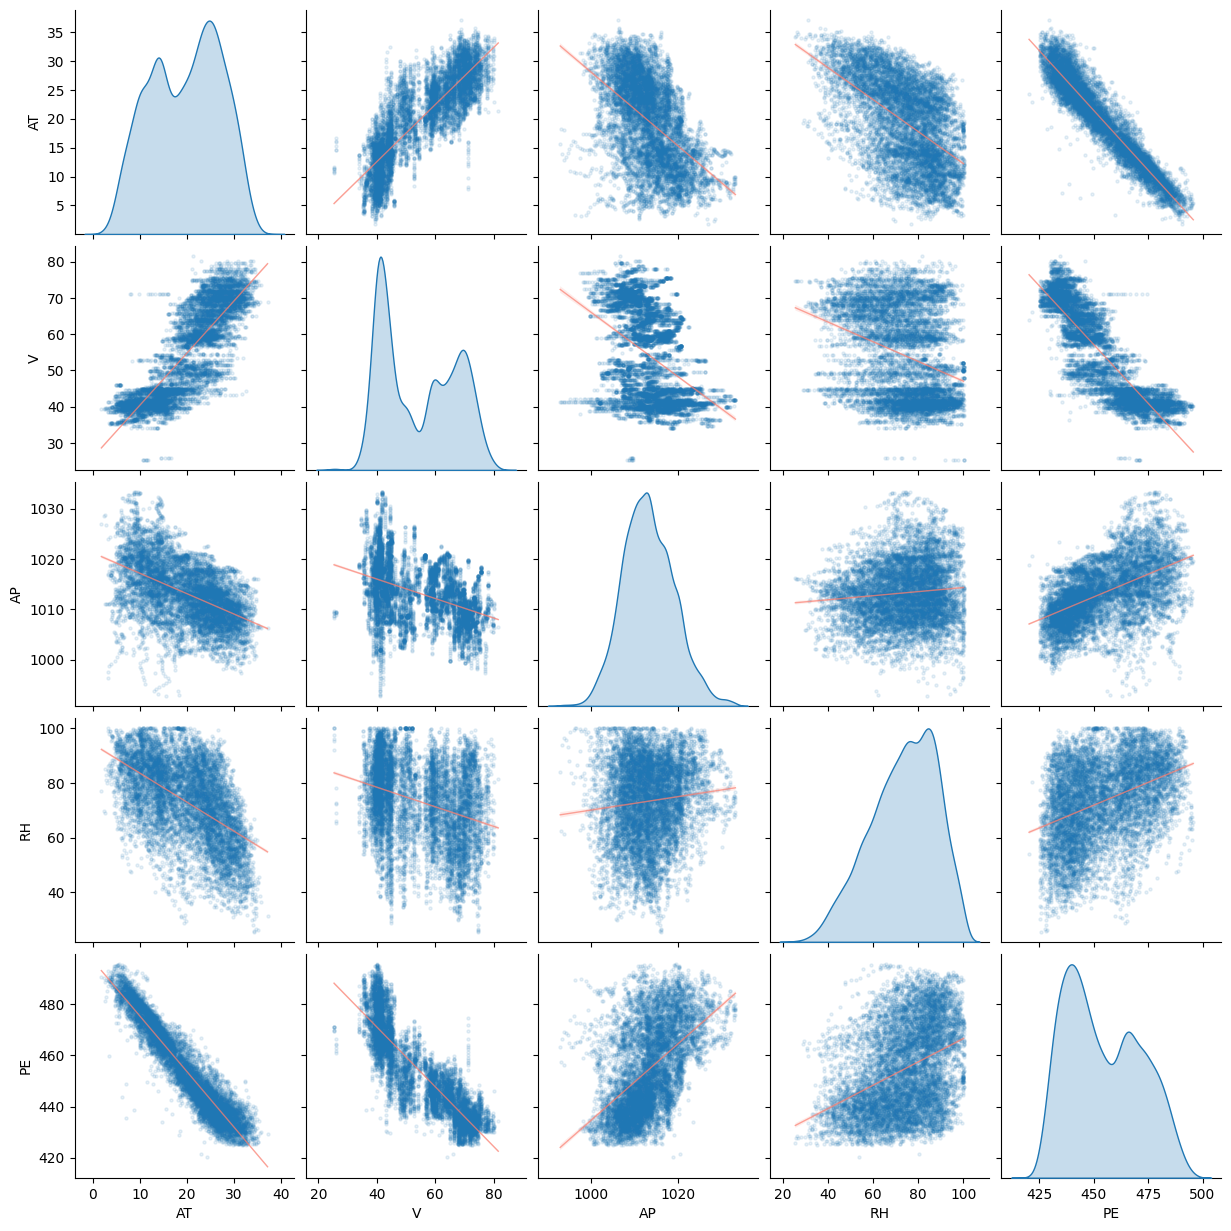

In [7]:
sns.pairplot(raw_data, diag_kind="kde", kind="reg", 
                         plot_kws={'line_kws':{'color': 'salmon', "linewidth": 1, 'alpha': 0.7}, 
                                   'scatter_kws': {'s': 5, 'alpha': 0.1}})

There seems to be a negative correlation between AT,V and PE

There seems to be a positive correlation between AT and V

iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them
in a table.

In [8]:
def get_statistics(col):
    
    # Mean
    data_mean=np.mean(col)

    # Median
    data_median=np.median(col)

    # Range
    data_min=min(col)
    data_max=max(col)
    data_range=data_max-data_min

    # First quartile (Q1)
    col_Q1 = np.percentile(col, 25)
    
    # Third quartile (Q3)
    col_Q3 = np.percentile(col, 75)
    
    # Interquaritle range (IQR)
    data_IQR = col_Q3 - col_Q1
    
    return [data_mean, data_median, data_range, col_Q1, col_Q3, data_IQR ]

In [9]:
# read column names into a list
predictors=list(raw_data.columns)

# initialize a blank dictionary with the column names
statistics_dict={}

# run the statistics function
for predictor in predictors:
    statistics_dict[predictor]=get_statistics(raw_data[predictor])
    
# copy the results into a dataframe
statistics_df=pd.DataFrame(statistics_dict, columns=predictors, index=['mean', 'median', 'range', 'first_quartile', 'third_quartile', 'inter-quartile_range' ])

statistics_df


,AT,V,AP,RH,PE
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
median,20.345000,52.080000,1012.940000,74.975000,451.550000
range,35.300000,56.200000,40.410000,74.600000,75.500000
first_quartile,13.510000,41.740000,1009.100000,63.327500,439.750000
third_quartile,25.720000,66.540000,1017.260000,84.830000,468.430000
inter-quartile_range,12.210000,24.800000,8.160000,21.502500,28.680000


##### (c) For each predictor, fit a simple linear regression model to predict the response.Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [16]:
def regression(x_train,y_train, multi_bool, poly_bool, interaction_bool, bias_bool):
    
    column_names=None
    
    if poly_bool==False:
        x_train_fit = statistical_m.add_constant(x_train, prepend=False)
        
    else:
        if interaction_bool==False:
            poly_features = PolynomialFeatures(3)
            x_train_fit=x_train.to_numpy().reshape(-1,1)
        
        else:
            poly_features = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = bias_bool)
        
        x_train_fit=poly_features.fit_transform(x_train)
        column_names=poly_features.get_feature_names(x_train.columns)
        
        
        
    # Training
    R_model=statistical_m.OLS(y_train, x_train_fit)
    R_model_results = R_model.fit()
    
    if column_names==None:
        print (R_model_results.summary())
        
    else:
        print (R_model_results.summary(xname=column_names))
        
    
    
    if poly_bool==False:
        if multi_bool==False:
            return R_model_results.params[0], R_model_results.params[1]

        
        else:
            return R_model_results.params
        
    else:
        return pd.DataFrame(np.expand_dims(R_model_results.params, axis=0), columns=[column_names])
    

In [12]:
y_data=raw_data['PE']

In [17]:
# initialize a blank dictionary with the column names
LR_coef={}
LR_const={}

Multi_bool=False
Poly_bool=False
Interaction_bool=False
Bias_bool=False

# run the LR function
for predictor in predictors[:4]:
   x_data=raw_data[[predictor]]
   LR_coef[predictor], LR_const[predictor] = regression(x_data, y_data, Multi_bool, Poly_bool, Interaction_bool, Bias_bool)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:37:17   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -2.1713      0.007   -291.715      0.0

In [18]:
from pprint import pprint
pprint(LR_coef)

{'AP': 1.489871673399113,
 'AT': -2.1713199585178105,
 'RH': 0.45565010226298014,
 'V': -1.168135126555741}


In [19]:
pprint(LR_const)

{'AP': -1055.2609889844387,
 'AT': 497.0341198927662,
 'RH': 420.9617661554837,
 'V': 517.8015263083873}


In [ ]:
# Outliers are observed in all the predictors from the pairwise scatter plots

##### (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 :βj =0?

In [366]:
# initialize a blank dictionary with the column names
MR_params={}

# run the LR function
x_data2=raw_data.iloc[:,:4]
Multi_bool=True
Poly_bool=False
Interaction_bool=False
Bias_bool=False

MR_params=regression(x_data2, y_data, Multi_bool, Poly_bool, Interaction_bool, Bias_bool)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:53:06   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -1.9775      0.015   -129.342      0.0

In [367]:
MR_params

AT        -1.977513
V         -0.233916
AP         0.062083
RH        -0.158054
const    454.609274
dtype: float64

NH can be rejected for AP and RH

##### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

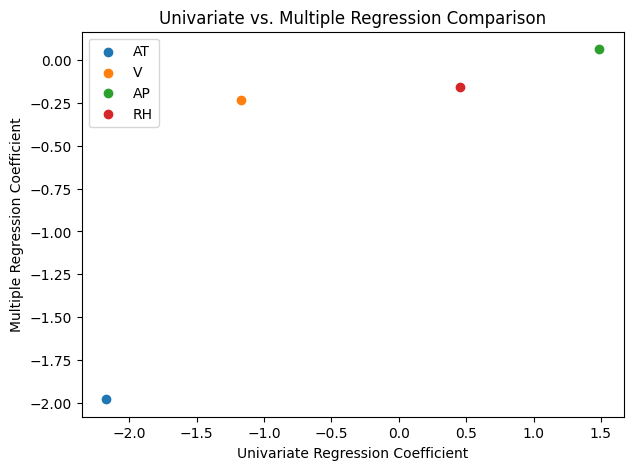

In [368]:
fig, axes = plt.subplots(figsize=(7, 5))

for predictor in predictors[:4]:
    axes.scatter(LR_coef[predictor], MR_params[predictor], label=predictor)
    
axes.set_xlabel('Univariate Regression Coefficient')
axes.set_ylabel('Multiple Regression Coefficient')
axes.set_title('Univariate vs. Multiple Regression Comparison')
axes.legend()

##### (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form
Y =β0 +β1X+β2X2 +β3X3 +ε

In [369]:
# initialize a blank pd frame with the column names
Poly_params=pd.DataFrame(index=predictors[:4], columns=["B0", "B1", "B2", "B3"])

Multi_bool=False
Poly_bool=True
Interaction_bool=False
Bias_bool=False

# run the Polynomial Regression function
for i,predictor in enumerate(predictors[:4]):
   x_data=raw_data[[predictor]]
   Poly_params.iloc[i] = regression(x_data, y_data, Multi_bool, Poly_bool, Interaction_bool, Bias_bool)



                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:53:15   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1            492.7281      0.673    732.248      0.0

/Users/osultan/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/osultan/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/osultan/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/osultan/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/

In [370]:
Poly_params

,B0,B1,B2,B3
AT,492.728143,-0.610346,-0.125138,0.002675
V,554.146849,-2.144377,-0.002712,0.000134
AP,0.074694,25.255593,-0.049952,0.000025
RH,468.413536,-1.729211,0.032145,-0.000152


##### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [371]:
# initialize a blank pd frame with the column names
Poly_params_interaction=pd.DataFrame(index=None)

# run the LR function
x_data3=raw_data.iloc[:,:4]
Multi_bool=False
Poly_bool=True
Interaction_bool=True
Bias_bool=True

Poly_params_interaction=regression(x_data3, y_data, Multi_bool, Poly_bool, Interaction_bool, Bias_bool)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:53:21   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1            685.7825     78.640      8.721      0.0

/Users/osultan/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [372]:
Poly_params_interaction

,1,AT,V,AP,RH,AT V,AT AP,AT RH,V AP,V RH,AP RH
0,685.782468,-4.347014,-7.674858,-0.152355,1.570907,0.020971,0.001759,-0.00523,0.006812,0.000839,-0.001612


Interactions are significant for all p<0.05

##### (h) Can you improve your model using possible interaction terms or nonlinear asso- ciations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regres- sion model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.


In [452]:
X_DATA=raw_data.iloc[:, :4]
Y_DATA=y_data

X_train, X_test, Y_train, Y_test= train_test_split(X_DATA, Y_DATA, test_size = 0.3)

In [453]:
X_train

,AT,V,AP,RH
3099,29.05,68.24,1007.88,42.67
2726,6.28,43.02,1013.72,88.13
3243,16.64,48.92,1011.55,78.76
630,23.28,60.84,1017.91,67.50
2660,26.44,71.77,1006.68,81.45
...,...,...,...,...
633,27.51,73.77,1002.42,90.88
4510,30.17,64.79,1017.06,43.81
8059,24.95,76.16,1006.20,76.16
2936,16.51,51.86,1022.37,81.18


In [454]:
# Training 
X_train = statistical_m.add_constant(X_train)
split_model_train = statistical_m.OLS(Y_train, X_train).fit()

#Training prediction
Y_train_predicted = split_model_train.predict(X_train)

# Testing Prediction
X_test = statistical_m.add_constant(X_test)
Y_test_predicted = split_model_train.predict(X_test)


In [455]:
from sklearn.metrics import mean_squared_error

MSE_Train_split = mean_squared_error(Y_train, Y_train_predicted)
print('The MSE on training data = 0.7 of dataset:', MSE_Train_split)

MSE_Test_split = mean_squared_error(Y_test, Y_test_predicted)
print('The MSE on test data = 0.3 of dataset:', MSE_Test_split)

The MSE on training data = 0.7 of dataset: 20.387314198303326
The MSE on test data = 0.3 of dataset: 21.69390989402604


In [456]:
def regression_optimization(expression, xy_data):
    
    # Train
    r_type = statistical_m_f.ols(formula = expression, data = xy_data)
    r_model = r_type.fit()
    
    # Predict
    Y_train_predicted_all_possibilities = r_model.predict(statistical_m.add_constant(X_train))
    Y_test_predicted_all_possibilities = r_model.predict(statistical_m.add_constant(X_test))
    
    # Evaluate
    MSE_Train_split = mean_squared_error(Y_train, Y_train_predicted_all_possibilities)
    MSE_Test_split = mean_squared_error(Y_test, Y_test_predicted_all_possibilities)
    
    print("The MSE on training data = 0.7 of dataset:",MSE_Train_split)
    print("The MSE on test data = 0.3 of dataset:", MSE_Test_split)
    print(r_model.pvalues)
    
    

In [457]:
# Create am expression of all possible interaction terms and quadratic non-linearities
Expression_1= 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2)+ AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH' 

# Concatenate the X_train and Y_train data to use for regression
XY_data=pd.concat([X_train, Y_train],axis = 1)

# Run regression optimization
regression_optimization(Expression_1, XY_data)


The MSE on training data = 0.7 of dataset: 17.661280503457665
The MSE on test data = 0.3 of dataset: 19.21304064903501
Intercept          3.405592e-08
AT                 2.701771e-02
V                  4.391480e-01
AP                 3.303598e-09
RH                 1.709873e-03
np.power(AT, 2)    1.545173e-06
np.power(V, 2)     9.291792e-02
np.power(AP, 2)    2.702103e-09
np.power(RH, 2)    1.105471e-05
AT:V               6.037046e-04
AT:AP              1.399389e-01
AT:RH              1.545969e-02
V:AP               5.545883e-01
V:RH               7.617132e-01
AP:RH              2.517687e-03
dtype: float64


In [458]:
# Updated expression of all possible interaction terms and quadratic non-linearities with insignificant variables  removed based on p values
Expression_2= 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(RH,2) + AT:V + AT:RH + AP:RH'

# Concatenate the X_train and Y_train data to use for regression
XY_data=pd.concat([X_train, Y_train],axis = 1)

# Run regression optimization
regression_optimization(Expression_2, XY_data)

The MSE on training data = 0.7 of dataset: 17.944411628694425
The MSE on test data = 0.3 of dataset: 19.43706195724118
Intercept          9.997412e-01
AT                 5.391672e-92
V                  1.429530e-05
AP                 3.085492e-18
RH                 2.829116e-14
np.power(AT, 2)    6.385145e-07
np.power(V, 2)     8.228764e-03
np.power(RH, 2)    9.521861e-10
AT:V               6.129158e-07
AT:RH              1.137493e-15
AP:RH              1.111643e-13
dtype: float64


##### (i) KNN Regression:
i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2,...,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [464]:
X_train, X_test, Y_train, Y_test= train_test_split(X_DATA, Y_DATA, test_size = 0.3)

In [465]:
def create_k_dictionary(N):
    
    k_range=list(range(1,N+1))
    k_result_dict=dict.fromkeys(k_range)

    return k_result_dict

In [466]:
# find values of k to loop through
k_dict=create_k_dictionary(100)

In [468]:
# Remove headers and index
X_train.reset_index(drop=True, inplace=True)
X_train.to_csv('X_train.csv', header=None, index=False)
X_train=pd.read_csv('X_train.csv', index_col=None, header=None)
os.remove('X_train.csv') 


X_test.reset_index(drop=True, inplace=True)
X_test.to_csv('X_test.csv', header=None, index=False)
X_test=pd.read_csv('X_test.csv', index_col=None, header=None)
os.remove('X_test.csv') 

In [469]:
X_train

,0,1,2,3
0,20.78,60.84,1018.66,80.40
1,11.06,41.50,1013.09,89.80
2,9.06,36.30,1015.14,58.71
3,23.20,61.02,1009.63,79.45
4,25.30,70.98,1007.22,95.10
...,...,...,...,...
6692,29.24,64.33,1011.49,65.08
6693,10.90,41.93,1014.96,96.24
6694,13.67,54.30,1015.92,75.42
6695,7.52,39.61,1018.61,78.96


In [470]:
X_test

,0,1,2,3
0,11.52,40.03,1017.56,87.87
1,14.23,46.18,1017.39,87.29
2,7.68,39.96,1023.73,87.48
3,10.17,41.46,1019.34,83.04
4,30.91,76.20,1008.53,58.08
...,...,...,...,...
2866,21.08,46.93,1014.49,63.33
2867,9.37,40.11,1024.94,75.03
2868,27.77,62.26,1010.88,66.45
2869,13.85,44.90,1019.11,76.79


In [482]:
min_MSE_test=100
best_k=None

MSE_test_list=[]
MSE_train_list=[]
k_inverse=[]
    
for k in k_dict.keys():

    # Train
    KNN_model_findk = KNeighborsRegressor(n_neighbors=k).fit(X_train, Y_train)
    
    #Predict
    y_pred_test = KNN_model_findk.predict(X_test)
    y_pred_train = KNN_model_findk.predict(X_train)

    #Perfromance Evaluation
    MSE_Train=mean_squared_error(Y_train, y_pred_train)
    MSE_Test=mean_squared_error(Y_test, y_pred_test)
    
    MSE_train_list.append(MSE_Train)
    MSE_test_list.append(MSE_Test)
    k_inverse.append(1/k)
    
    
    if MSE_Test < min_MSE_test:
        min_MSE_test= MSE_Test
        min_MSE_train=MSE_Train
        best_k=k
        
print("The MSE on test data = 0.3 of dataset:", min_MSE_test)
print("The MSE on train data = 0.7 of dataset:", min_MSE_train)
print("The best k:", best_k)

The MSE on test data = 0.3 of dataset: 17.00540243914238
The best k: 6


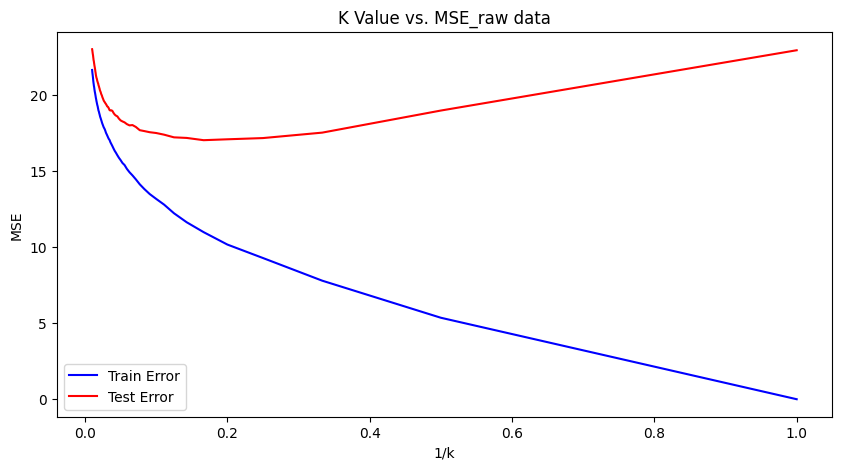

In [485]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(k_inverse,MSE_train_list, color='blue', label='Train Error')
ax.plot(k_inverse,MSE_test_list, color='red', label='Test Error')


ax.set_xlabel('1/k')
ax.set_ylabel('MSE')
ax.set_title('K Value vs. MSE_raw data')
ax.legend()

In [490]:
min_MSE_test=100
best_k=None

MSE_test_list=[]
MSE_train_list=[]
k_inverse=[]

X_train=normalize(X_train)
X_test=normalize(X_test)
    
for k in k_dict.keys():

    # Train
    KNN_model_findk = KNeighborsRegressor(n_neighbors=k).fit(X_train, Y_train)
    
    #Predict
    y_pred_test = KNN_model_findk.predict(X_test)
    y_pred_train = KNN_model_findk.predict(X_train)

    #Perfromance Evaluation
    MSE_Train=mean_squared_error(Y_train, y_pred_train)
    MSE_Test=mean_squared_error(Y_test, y_pred_test)
    
    MSE_train_list.append(MSE_Train)
    MSE_test_list.append(MSE_Test)
    k_inverse.append(1/k)
    
    
    if MSE_Test < min_MSE_test:
        min_MSE_test= MSE_Test
        min_MSE_train=MSE_Train
        best_k=k
        
print("The MSE on test data = 0.3 of dataset:", min_MSE_test)
print("The MSE on train data = 0.7 of dataset:", min_MSE_train)
print("The best k:", best_k)

The MSE on test data = 0.3 of dataset: 18.31220553674678
The MSE on train data = 0.7 of dataset: 14.105000627445122
The best k: 10


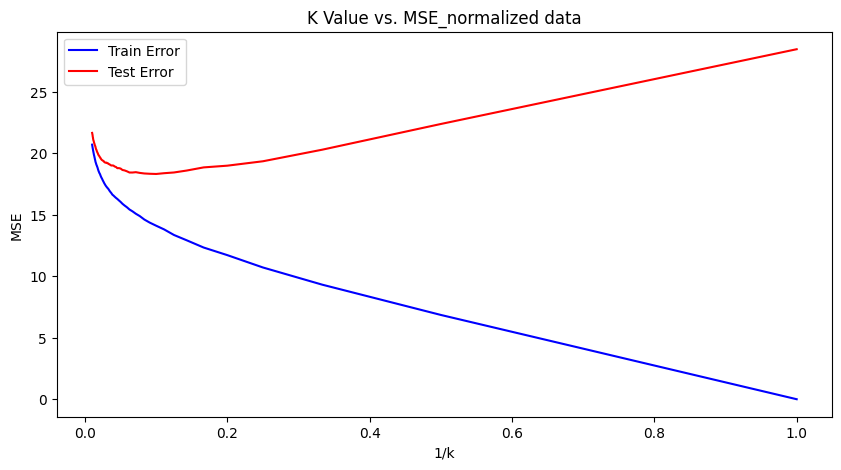

In [491]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(k_inverse,MSE_train_list, color='blue', label='Train Error')
ax.plot(k_inverse,MSE_test_list, color='red', label='Test Error')


ax.set_xlabel('1/k')
ax.set_ylabel('MSE')
ax.set_title('K Value vs. MSE_normalized data')
ax.legend()

##### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

KNN error using raw data vs using normalized has no major difference. 

2. ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predic- tors p is small.

Ans: flexible will be better. for large sample size inflexible method will be underfit. 

(b) The number of predictors p is extremely large, and the number of observations n is small.

Ans: inflexible will be better. for large sample size flexible method will be overfit

(c) The relationship between the predictors and response is highly non-linear.

Ans: flexible will show non-linearity better

(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.

Ans: high noise will not work with flexible method therefore inflexible is better

3. ISLR: 2.4.7

D1=sqrt(3^2)=3
d2=sqrt(2^2)=2
d3=sqrt(1+3^2)=3.16
d4=sqrt(1+2^2)=2.23
d5=sqrt(1+1)=1.41
d6=sqrt(1+1+1)=1.73

(b) green

(c) red

(d) k must be small
